In [4]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from functools import lru_cache
from numpy.random import default_rng

import pylab 
import scipy.stats as stats
import pickle

In [5]:
a=4.0232/2

N=1
s=1
m=1
A=1
J=N*m
MHz = 1e6
kHz = 1e3
us = 1e-6
T = N/(A*m)
mu0 = 4*np.pi*1e-7 * (N/A**2)
hbar = 1.054571817 * 1e-34 * (J*s)
gammaF = 2*np.pi * 40.078 * (MHz/T) # spin 1/2
gammaE = 2*np.pi * 28024.9514242 * (MHz/T) # spin 1/2 
gammaLi = 2*np.pi * 16.546 * (MHz/T) # spin 3/2

# coupling strengths in Hz * A**3
Jf = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaF**2 * (10**10)**3
Jlif = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaLi*gammaF * (10**10)**3

In [20]:
r0 = 16

n_f_atoms =4*r0**3+6*r0**2+3*r0+1
n_li_atoms = n_f_atoms-1

odds=list(range(-r0,r0+1,2))
evens=list(range(-r0+1,r0+1,2))
def flatten(xsss):
    return [x for xss in xsss for xs in xss for x in xs]

In [21]:
n_f_atoms

17969

In [22]:
def disorder_var_analytic(r0,B=(0,0,1)):
    #
    # Compute the disorder field variance for a 3d LiF
    # crystal at the origin with Manhattan radius r0, corresponding
    # to N=4*r0**3+6*r0**2+3*r0 Li spins. NOTE: r0 must even for
    # the origin to be a fluorine spin
    #
    odds=list(range(-r0,r0+1,2))
    evens=list(range(-r0+1,r0+1,2))
    def flatten(xsss):
        return [x for xss in xsss for xs in xss for x in xs]
    li_atom_pos = flatten([[[(i*a,j*a,k*a) for i in odds] for j in evens] for k in odds]) + flatten([[[(i*a,j*a,k*a) for i in evens] for j in odds] for k in odds])
    li_atom_pos += flatten([[[(i*a,j*a,k*a) for i in odds] for j in odds] for k in evens]) + flatten([[[(i*a,j*a,k*a) for i in evens] for j in evens] for k in evens])
    
    def lif_coupling_3d(posF, posLi, B=(0,0,1)):
        #
        # compute the coupling matrix element of two fluorine spins
        # relative to a large external B field, in a 3d lattice
        #
        if type(posF) is int:
            posF = f_atom_pos[posF]
        if type(posLi) is int:
            posLi = li_atom_pos[posLi]
            
        r = (np.array(posF)-np.array(posLi))
        d = la.norm(r)
        if d < 1e-8:
            return 0
        bdir = np.array(B) / la.norm(np.array(B))
        cos = (r @ bdir) / d
        return Jlif * (1-3*cos**2) / d**3

    couplings = np.array([1.25*lif_coupling_3d((0,0,0),rj,B)**2 for rj in li_atom_pos])
    return sum(couplings)


def homo_var_analytic(r0,B=(0,0,1)):
    #
    # Compute the homonuclear crystal field variance for a 3d LiF
    # crystal at the origin with Manhattan radius r0, corresponding
    # to N=4*r0**3+6*r0**2+3*r0+1 F spins. NOTE: r0 must even for
    # the origin to be a fluorine spin
    #
    odds=list(range(-r0,r0+1,2))
    evens=list(range(-r0+1,r0+1,2))
    def flatten(xsss):
        return [x for xss in xsss for xs in xss for x in xs]
    f_atom_pos = flatten([[[(i*a,j*a,k*a) for i in odds] for j in odds] for k in odds]) + flatten([[[(i*a,j*a,k*a) for i in evens] for j in evens] for k in odds])
    f_atom_pos += flatten([[[(i*a,j*a,k*a) for i in evens] for j in odds] for k in evens]) + flatten([[[(i*a,j*a,k*a) for i in odds] for j in evens] for k in evens])
    
    def f_coupling_3d(posi, posj, B=(0,0,1)):
        #
        # compute the coupling matrix element of two fluorine spins
        # relative to a large external B field, in a 3d lattice
        #
        if posi == posj:
            return 0
        if type(posi) is int:
            posi = f_atom_pos[posi]
        if type(posj) is int:
            posj = f_atom_pos[posj]
            
        r = (np.array(posi)-np.array(posj))
        d = la.norm(r)
        if d < 1e-8:
            return 0

        bdir = np.array(B) / la.norm(np.array(B))
        cos = (r @ bdir) / d
        return Jf * (1-3*cos**2) / d**3

    couplings = np.array([0.25*f_coupling_3d((0,0,0),rj,B)**2 for rj in f_atom_pos])
    return sum(couplings)

In [23]:
f_atom_pos = flatten([[[(i*a,j*a,k*a) for i in odds] for j in odds] for k in odds]) + flatten([[[(i*a,j*a,k*a) for i in evens] for j in evens] for k in odds])
f_atom_pos += flatten([[[(i*a,j*a,k*a) for i in evens] for j in odds] for k in evens]) + flatten([[[(i*a,j*a,k*a) for i in odds] for j in evens] for k in evens])

li_atom_pos = flatten([[[(i*a,j*a,k*a) for i in odds] for j in evens] for k in odds]) + flatten([[[(i*a,j*a,k*a) for i in evens] for j in odds] for k in odds])
li_atom_pos += flatten([[[(i*a,j*a,k*a) for i in odds] for j in odds] for k in evens]) + flatten([[[(i*a,j*a,k*a) for i in evens] for j in evens] for k in evens])
#li_atom_pos = flatten([[(i*a,j*a) for i in odds] for j in evens]) + flatten([[(i*a,j*a) for i in evens] for j in odds])

In [24]:
(0,0,0) in f_atom_pos

True

In [25]:
len(li_atom_pos)

17968

In [26]:
len(f_atom_pos)

17969

In [27]:

def f_coupling_3d(posi, posj, B=(0,0,1)):
    #
    # compute the coupling matrix element of two fluorine spins
    # relative to a large external B field, in a 3d lattice
    #
    if posi == posj:
        return 0
    if type(posi) is int:
        posi = f_atom_pos[posi]
    if type(posj) is int:
        posj = f_atom_pos[posj]
        
    r = (np.array(posi)-np.array(posj))
    d = la.norm(r)
    if d < 1e-8:
        return 0

    bdir = np.array(B) / la.norm(np.array(B))
    cos = (r @ bdir) / d
    return Jf * (1-3*cos**2) / d**3


@lru_cache
def lif_coupling_3d(posF, posLi, B=(0,0,1)):
    #
    # compute the coupling matrix element of two fluorine spins
    # relative to a large external B field, in a 3d lattice
    #
    if type(posF) is int:
        posF = f_atom_pos[posF]
    if type(posLi) is int:
        posLi = li_atom_pos[posLi]
        
    r = (np.array(posF)-np.array(posLi))
    d = la.norm(r)
    if d < 1e-8:
        return 0

    # note: convert to dot-product in 3d for more efficient implementation
    bdir = np.array(B) / la.norm(np.array(B))
    cos = (r @ bdir) / d
    return Jlif * (1-3*cos**2) / d**3

def lif_corr_3d(r,B=(0,0,1)):
    #
    # compute the spatial correlation of the disordered field
    # at position r relative to the origin, in a LiF crystal with
    # the magnetic field pointing along the the B direction.
    #
    couplings = np.array([1.25*lif_coupling_3d(r,rj,B)*lif_coupling_3d((0,0,0),rj,B) for rj in li_atom_pos])
    return sum(couplings)
    

In [28]:
couplings = np.array([f_coupling_3d((0,0,0), ri, B=(1,1,1)) for ri in f_atom_pos])
sorted_couplings = np.sort(abs(couplings))

In [29]:
np.max(couplings)

4622.72689589558

In [30]:
np.argmax(abs(couplings))

7080

In [15]:
largest_indices = np.argsort(abs(couplings))[-56:-38]
largest_indices

array([4915, 5094, 6947, 6806, 4939, 5070, 7118, 2970, 5251, 3284, 4758,
       6635, 2981, 3295, 4913, 6975, 6778, 5096], dtype=int64)

In [16]:
for idx in largest_indices:
    print(f_atom_pos[idx])

(2.0116, -4.0232, -2.0116)
(-2.0116, 4.0232, 2.0116)
(-4.0232, -2.0116, 2.0116)
(4.0232, 2.0116, -2.0116)
(2.0116, 4.0232, -2.0116)
(-2.0116, -4.0232, 2.0116)
(4.0232, 2.0116, 6.034800000000001)
(-2.0116, -6.034800000000001, -4.0232)
(2.0116, 4.0232, 6.034800000000001)
(6.034800000000001, 2.0116, 4.0232)
(-2.0116, -4.0232, -6.034800000000001)
(-4.0232, -2.0116, -6.034800000000001)
(-6.034800000000001, -2.0116, -4.0232)
(2.0116, 6.034800000000001, 4.0232)
(-6.034800000000001, -4.0232, -2.0116)
(4.0232, 6.034800000000001, 2.0116)
(-4.0232, -6.034800000000001, -2.0116)
(6.034800000000001, 4.0232, 2.0116)


In [17]:
couplings[largest_indices]

array([ 296.54806864,  296.54806864,  296.54806864,  296.54806864,
        296.54806864,  296.54806864, -392.23452828, -392.23452828,
       -392.23452828, -392.23452828, -392.23452828, -392.23452828,
       -392.23452828, -392.23452828, -392.23452828, -392.23452828,
       -392.23452828, -392.23452828])

In [18]:
1482.74034319/4622.7268959

0.3207501495502742

In [19]:
889.64420591/4622.7268959

0.19245008972929922

In [20]:
629.07345084/4622.728959

0.13608270275402057

In [21]:
round(577.84086199/4622.728959,4)

0.125

In [22]:
2.96548069e+02/4622.728959

0.06415000135853736

In [23]:
n7_adjacency= [2*a*alpha*(np.array([1,1,1])-2*ei) for alpha in (-1,1) for ei in np.identity(3)]
n7_adjacency += [a*np.array([alpha,-alpha,2*beta]) for alpha in (-1,1) for beta in (-1,1)]
n7_adjacency += [a*np.array([alpha,2*beta,-alpha]) for alpha in (-1,1) for beta in (-1,1)]
n7_adjacency += [a*np.array([2*beta,alpha,-alpha]) for alpha in (-1,1) for beta in (-1,1)]

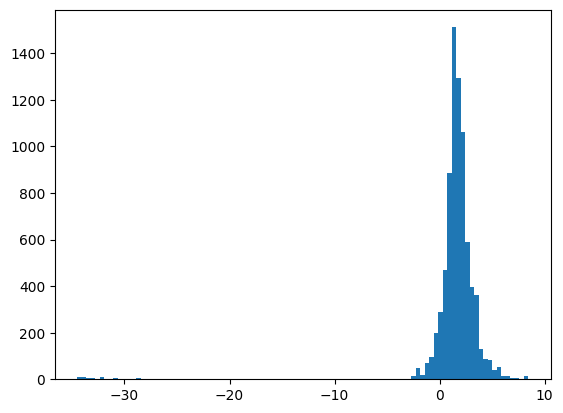

In [24]:
plt.hist(
    np.log(abs(sorted_couplings[19:])),
    bins=100,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

In [25]:
rf=15
perp = [(1*a*k,-1*a*k,0) for k in range(1,rf,1)]
vert = [(0,0,2*a*k) for k in range(1,rf,1)]
diag = [(2*a*k,2*a*k, 2*a*k) for k in range(1,rf,1)]
rVec = np.array([2*a*k for k in range(1,rf,1)])
rdVec = np.sqrt(3)*rVec
rpVec = (1/np.sqrt(2))*rVec

In [26]:
try:
    perpC = pickle.load(open("perpC.dat", "rb"))
    vertC = pickle.load(open("vertC.dat", "rb"))
    diagC = pickle.load(open("diagC.dat", "rb"))
except (OSError, IOError) as e:
    perpC = np.array([lif_corr_3d(r,(1,1,1)) for r in perp])
    vertC = np.array([lif_corr_3d(r,(1,1,1)) for r in vert])
    diagC = np.array([lif_corr_3d(r,(1,1,1)) for r in diag])
    with open('perpC.dat', 'wb') as fi:
        pickle.dump(perpC, fi)
    with open('vertC.dat', 'wb') as fi:
        pickle.dump(vertC, fi)
    with open('diagC.dat', 'wb') as fi:
        pickle.dump(diagC, fi)

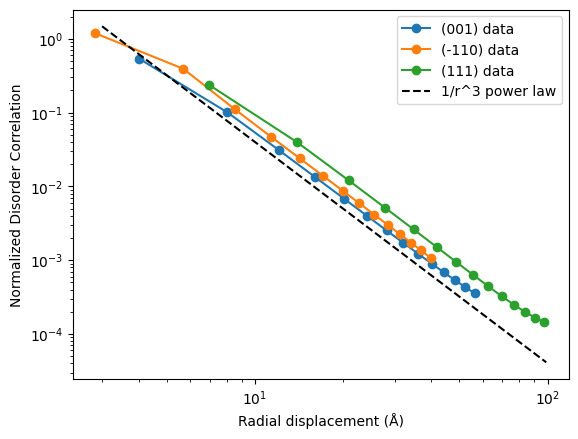

In [27]:
std=4700
rsmooth = np.arange(3.,100.,1.)

plt.loglog(rVec, abs(vertC)/std**2,marker='o',label="(001) data")
plt.loglog(rpVec, abs(perpC)/std**2,marker='o',label="(-110) data")
plt.loglog(rdVec, diagC/std**2,marker='o',label='(111) data')


plt.loglog(rsmooth, 40*rsmooth**-3,linestyle='--',color="black",label="1/r^3 power law")


plt.legend()
plt.xlabel(r"Radial displacement (Å)")
plt.ylabel("Normalized Disorder Correlation")
plt.show()

In [16]:
def rand_spin_dir(atoms, s=2):
    rng = default_rng()
    return np.array([rng.integers(low=0, high=s) - (s - 1) / 2 for _ in range(atoms)])

def mean_field_instance(idx1, idx2, B=(0,0,1)):
    if idx1 < idx2:
        couplings = [2*(f_coupling_3d(i,idx1,B)-f_coupling_3d(i,idx2,B)) for i in range(idx1)]
        couplings += [2*(f_coupling_3d(i,idx1,B)-f_coupling_3d(i,idx2,B)) for i in range(idx1+1,idx2)]
        couplings += [2*(f_coupling_3d(i,idx1,B)-f_coupling_3d(i,idx2,B)) for i in range(idx2+1, n_f_atoms)]
    else:
        couplings = [2*(f_coupling_3d(i,idx1,B)-f_coupling_3d(i,idx2,B)) for i in range(idx2)]
        couplings += [2*(f_coupling_3d(i,idx1,B)-f_coupling_3d(i,idx2,B)) for i in range(idx2+1,idx1)]
        couplings += [2*(f_coupling_3d(i,idx1,B)-f_coupling_3d(i,idx2,B)) for i in range(idx1+1, n_f_atoms)]
    return np.array(couplings) @ rand_spin_dir(n_f_atoms-2)

def dis_field_instance(f_pos, B=(0,0,1)):
    couplings = [lif_coupling_3d(f_pos, idx, B) for idx in range(n_li_atoms)]
    return np.array(couplings) @ rand_spin_dir(n_li_atoms,s=4)

def dis_field_correlation(f_source, targets, B=(0,0,1)):
    source_coupling = [lif_coupling_3d(f_source, idx,B) for idx in range(n_li_atoms)]
    target_couplings = [[lif_coupling_3d(target, idx,B) for idx in range(n_li_atoms)] for target in targets]
    state = rand_spin_dir(n_li_atoms,s=4)
    tr1 = (np.array(source_coupling) @ state)
    return np.array([tr1 * (np.array(target_coupling) @ state) for target_coupling in target_couplings])

def dis_field_sin_correlation(f_source, targets, time, B=(0,0,1)):
    state = rand_spin_dir(n_li_atoms,s=4)
    source_coupling = np.array([lif_coupling_3d(f_source, idx,B) for idx in range(n_li_atoms)])
    omega0 = 2 * np.pi * state @ source_coupling
    target_couplings = [np.array([lif_coupling_3d(target, idx ,B) for idx in range(n_li_atoms)]) for target in targets]
    omega_list =  [2 * np.pi * state @ targ_coup for targ_coup in target_couplings]
    return np.array([np.sin(omega0*time)*np.sin(omega*time) for omega in omega_list])

In [29]:
origin = f_atom_pos.index((0,0,0))

rf = int(r0/2)

h1 = [(2*a*k,0,0) for k in range(1,rf,1)]
h2 = [(0,2*a*k,0) for k in range(1,rf,1)]
vert = [(0,0,2*a*k) for k in range(1,rf,1)]
diag = [(2*a*k,2*a*k, 2*a*k) for k in range(1,rf,1)]
rVec = np.array([2*a*k for k in range(1,rf,1)])
rdVec = np.sqrt(3)*rVec


In [30]:
trials=10000
# one of the nearest neighbors of the origin
rk = f_atom_pos.index((a,a,0))
distro_nn = np.array([mean_field_instance(origin, rk, B=(1,1,1))/4 for _ in range(trials)])

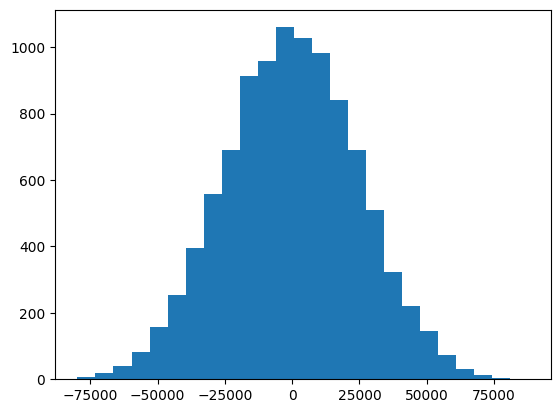

24633.485946839566

In [44]:
plt.hist(
    distro_nn*4,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

h1_nn_std = np.std(distro_nn*4)
h1_nn_std

In [39]:
trials=10000
# one of the nearest neighbors of the origin
rk = f_atom_pos.index((a,0,-a))
distro_nn_other = np.array([mean_field_instance(origin, rk, B=(1,1,1))/4 for _ in range(trials)])

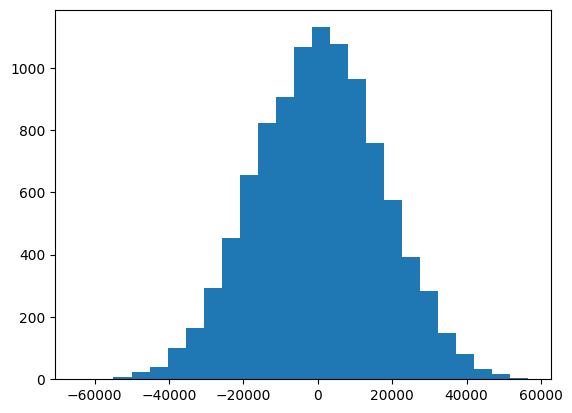

16992.512884250802

In [45]:
plt.hist(
    distro_nn_other*4,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

nn_std = np.std(distro_nn_other*4)
nn_std

In [41]:
trials=10000
# one of the nearest neighbors of the origin
rk = f_atom_pos.index((0,-a,a))
distro_nn_other = np.array([mean_field_instance(origin, rk, B=(1,1,1))/4 for _ in range(trials)])

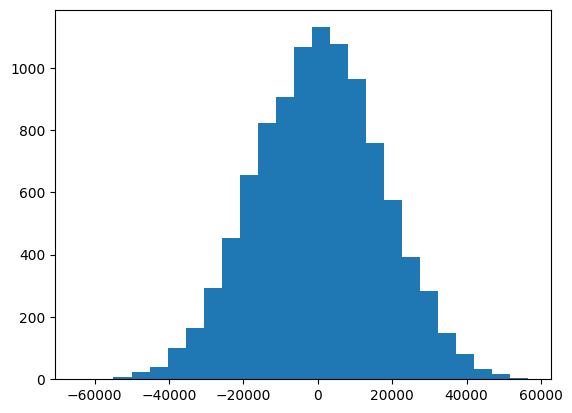

16992.512884250802

In [46]:
plt.hist(
    distro_nn_other*4,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

nn_std = np.std(distro_nn_other*4)
nn_std

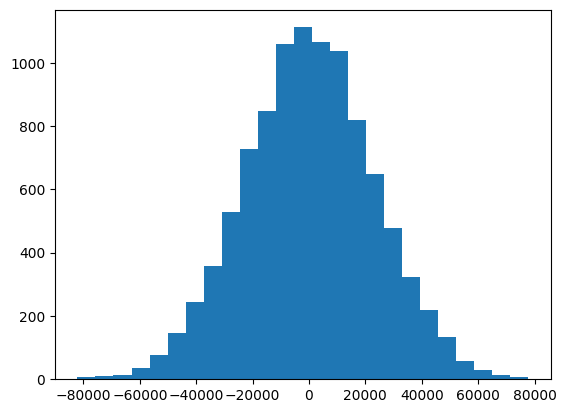

23045.447668847293

In [34]:
trials=10000
# along the (1,1,1) direction
rk = f_atom_pos.index((2*a,2*a,2*a))
distro_h2_nn = [mean_field_instance(origin, rk, B=(1,1,1) ) for _ in range(trials)]

plt.hist(
    distro_h2_nn,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

h2_nn_std = np.std(distro_h2_nn)
h2_nn_std

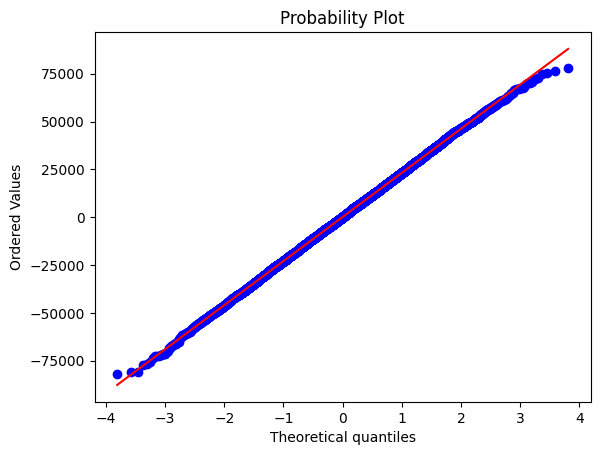

In [35]:
stats.probplot(distro_h2_nn, dist="norm", plot=pylab)
pylab.show()

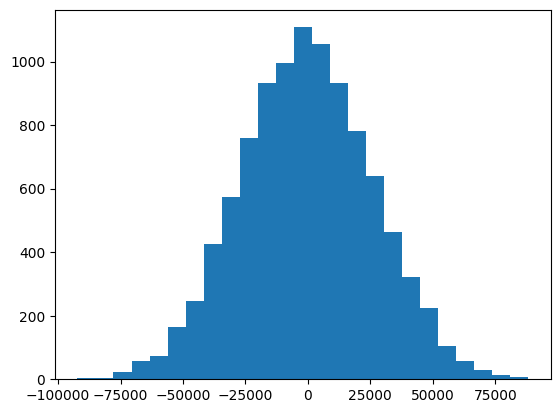

26312.383473917947

In [36]:
trials=10000
# in plane, next nearest neighbor
rk = f_atom_pos.index((0,2*a,0))
distro_diag_nn = [mean_field_instance(origin, rk, B=(1,1,1) ) for _ in range(trials)]

plt.hist(
    distro_diag_nn,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

diag_nn_std = np.std(distro_diag_nn)
diag_nn_std

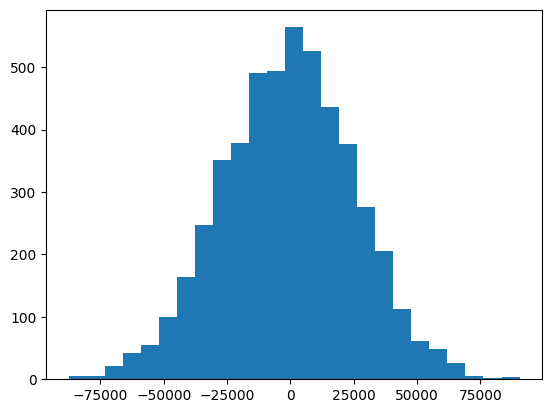

26006.776962902673

In [47]:
trials=5000
# in plane, next nearest neighbor
rk = f_atom_pos.index((0,0,-2*a))
dist1 = [mean_field_instance(origin, rk, B=(1,1,1) ) for _ in range(trials)]

plt.hist(
    dist1,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

d1 = np.std(dist1)
d1

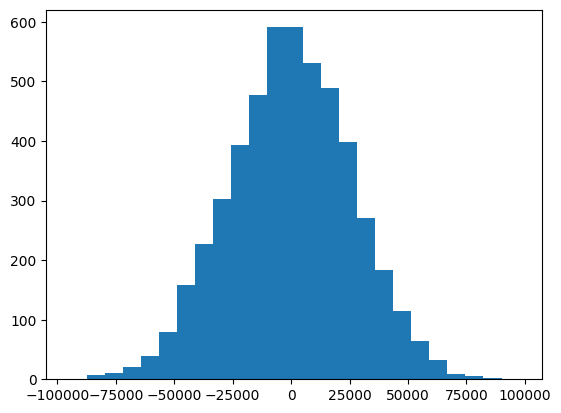

26187.853446568926

In [49]:
trials=5000
# in plane, next nearest neighbor
rk = f_atom_pos.index((2*a,0,0))
dist1 = [mean_field_instance(origin, rk, B=(1,1,1) ) for _ in range(trials)]

plt.hist(
    dist1,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

d1 = np.std(dist1)
d1

In [31]:
import os

filename = "li_disorder_distro.dat"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        distro111 = pickle.load(f)
else:
    with open(filename, "wb") as f:
        trials=10000
        distro111 = [dis_field_instance( (0,0,0), B=(1,1,1) ) for _ in range(trials)]
        pickle.dump(distro111, f)

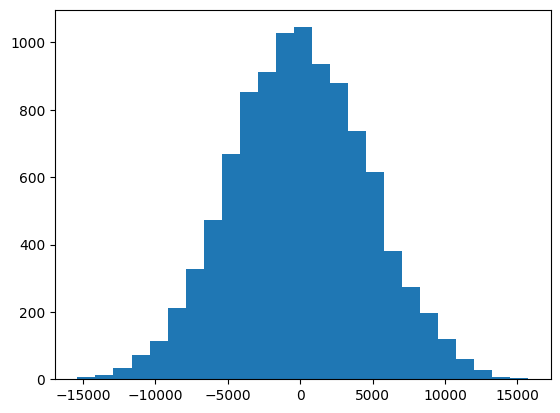

4686.985149057583

In [32]:
plt.hist(
    distro111,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

std = np.std(distro111)
std

In [1]:
26/4.7

5.531914893617021

In [2]:
19/4.7

4.042553191489362

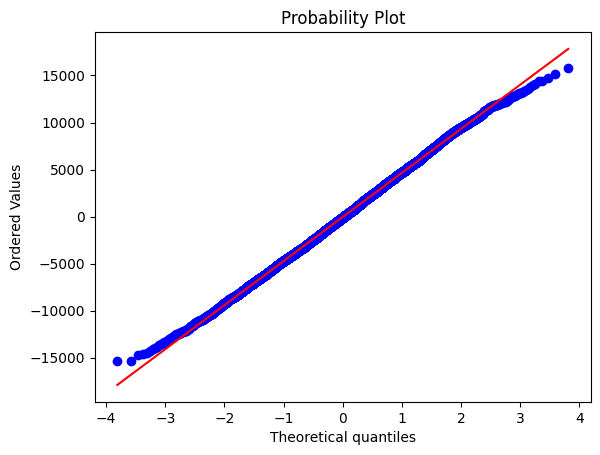

In [33]:
stats.probplot(distro111, dist="norm", plot=pylab)
pylab.show()

In [18]:
rf=5
k_vals = np.arange(-rf,rf+1,1)
para = [(2*k*a,2*k*a,2*k*a) for k in k_vals]
perp = [(k*a,-k*a,0) for k in k_vals]
horiz = [(k*a,0,0) for k in k_vals]

In [19]:
trials=5000
B = (1,1,1)

distro_para = np.array([dis_field_correlation( (0,0,0) , para, B=B ) for _ in range(trials)]).T

distro_perp = np.array([dis_field_correlation( (0,0,0) , perp, B=B ) for _ in range(trials)]).T

distro_horiz = np.array([dis_field_correlation( (0,0,0) , horiz, B=B ) for _ in range(trials)]).T

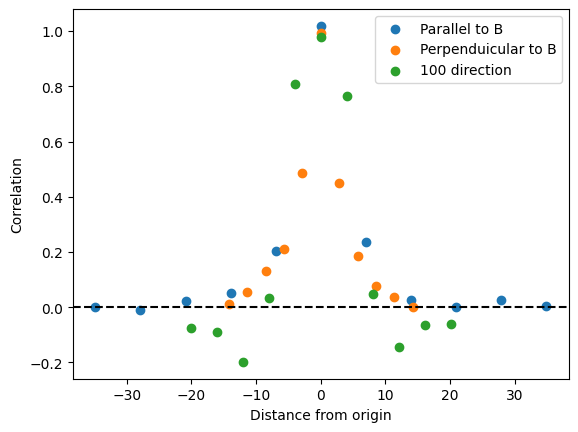

In [ ]:
plt.scatter(np.sqrt(12)*k_vals*a,np.mean(distro_para,axis=1)/std**2,label="Parallel to B")
plt.scatter(np.sqrt(2)*k_vals*a,np.mean(distro_perp,axis=1)/std**2,label="Perpenduicular to B")
plt.scatter(2*k_vals*a,np.mean(distro_horiz,axis=1)/std**2,label="100 direction")

plt.axhline(y=0,color='black',linestyle='--')
plt.xlabel("Distance from origin")
plt.ylabel("Correlation")
plt.legend()
plt.show()

In [21]:
para_sin_distros = {}
perp_sin_distros = {}
horiz_sin_distros = {}
Bdir = (1,1,1)
trials=5000

times = [5*us, 50*us, 100*us, 200*us, 300*us, 400*us]

for time in times:
    para_sin_distros[time] = np.array([dis_field_sin_correlation( (0,0,0) , para, time, B=Bdir) for _ in range(trials)]).T
    perp_sin_distros[time] = np.array([dis_field_sin_correlation( (0,0,0) , perp, time, B=Bdir) for _ in range(trials)]).T
    horiz_sin_distros[time] = np.array([dis_field_sin_correlation( (0,0,0) , horiz, time, B=Bdir) for _ in range(trials)]).T

In [ ]:
try:
    times = [5*us, 50*us, 65*us, 70*us, 75*us, 100*us, 200*us, 300*us, 400*us]
    para_sin_distros = pickle.load(open("para_sin_distros.dat", "rb"))
    perp_sin_distros = pickle.load(open("perp_sin_distros.dat", "rb"))
    horiz_sin_distros = pickle.load(open("horiz_sin_distros.dat", "rb"))

except (OSError,IOError) as e:
    times = [5*us, 50*us, 65*us, 70*us, 75*us, 100*us, 200*us, 300*us, 400*us]
    para_sin_distros = {}
    perp_sin_distros = {}
    horiz_sin_distros = {}
    Bdir = (1,1,1)
    trials=5000
    for time in times:
        para_sin_distros[time] = np.array([dis_field_sin_correlation( (0,0,0) , para, time, B=Bdir) for _ in range(trials)]).T
        perp_sin_distros[time] = np.array([dis_field_sin_correlation( (0,0,0) , perp, time, B=Bdir) for _ in range(trials)]).T
        horiz_sin_distros[time] = np.array([dis_field_sin_correlation( (0,0,0) , horiz, time, B=Bdir) for _ in range(trials)]).T
    with open('para_sin_distros.dat', 'wb') as fi:
        pickle.dump(para_sin_distros, fi)
    with open('perp_sin_distros.dat', 'wb') as fi:
        pickle.dump(perp_sin_distros, fi)
    with open('horiz_sin_distros.dat', 'wb') as fi:
        pickle.dump(horiz_sin_distros, fi)

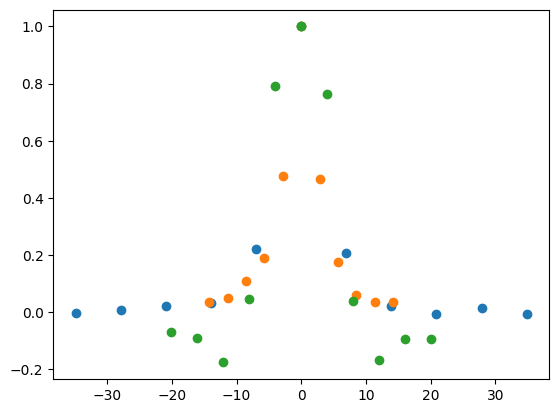

In [ ]:
time = 5

para_d = np.sqrt(12)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)

horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))

plt.show()

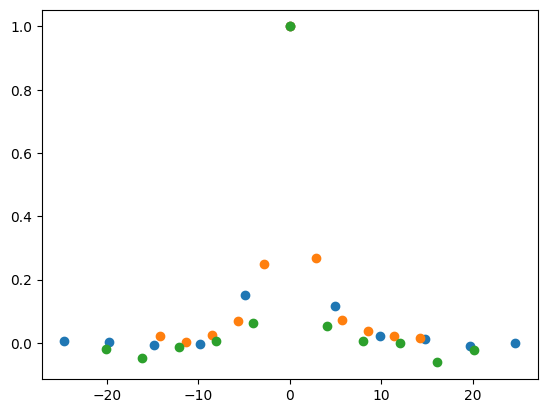

In [46]:
time = 50*us

para_d = np.sqrt(6)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)


horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))



#plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
#plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')

t = np.arange(-20,20,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.show()

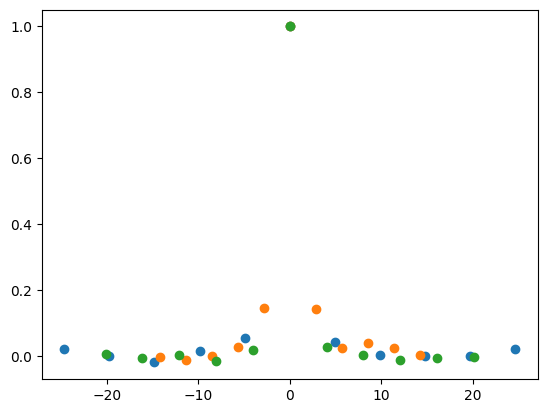

In [57]:
time = 65*us

para_d = np.sqrt(6)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)


horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))



#plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
#plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')

t = np.arange(-20,20,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.show()

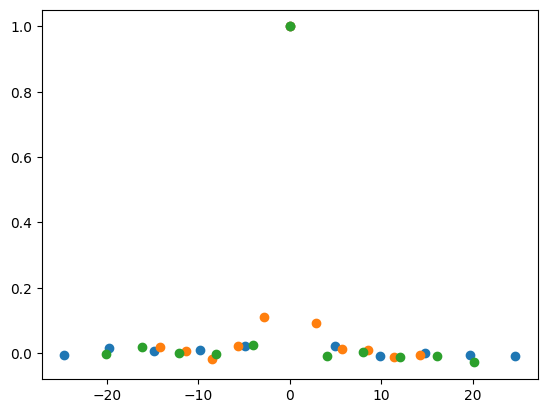

In [59]:
time = 70*us

para_d = np.sqrt(6)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)


horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))



#plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
#plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')

t = np.arange(-20,20,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.show()

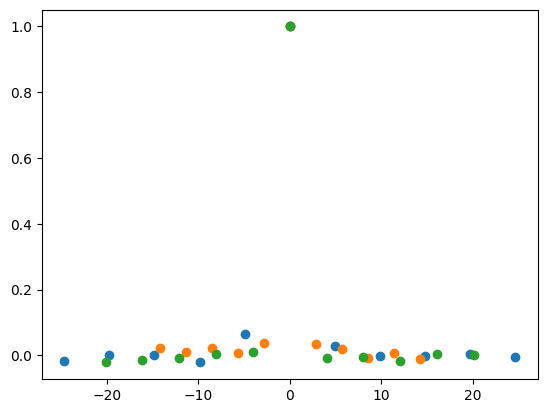

In [55]:
time = 75*us

para_d = np.sqrt(6)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)


horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))



#plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
#plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')

t = np.arange(-20,20,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.show()

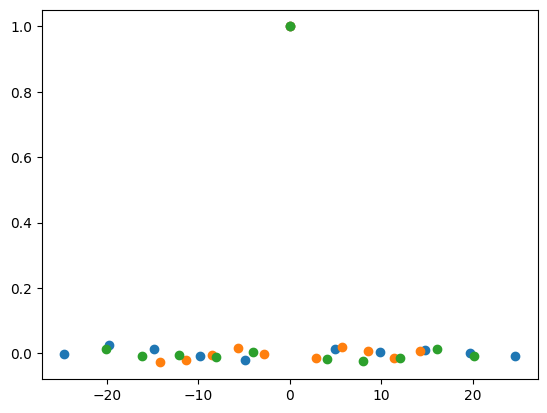

In [47]:
time = 100*us

para_d = np.sqrt(6)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)

horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))


#plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
#plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')

t = np.arange(-20,20,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.show()

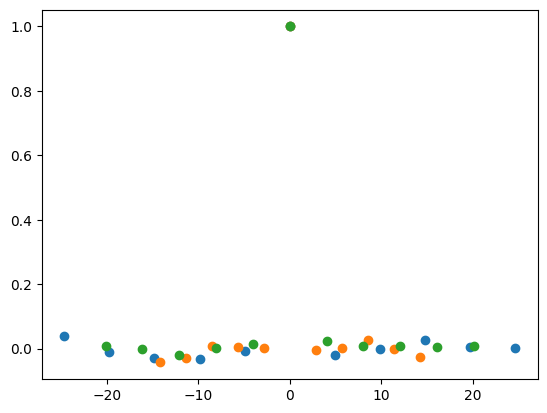

In [41]:
time = 200*us

para_d = np.sqrt(6)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)
#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")

horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))



t = np.arange(-20,20,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.show()

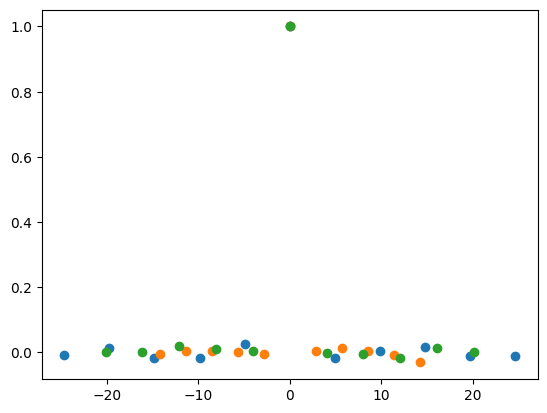

In [42]:
time = 300*us

para_d = np.sqrt(6)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)
#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")

horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))



t = np.arange(-20,20,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.show()

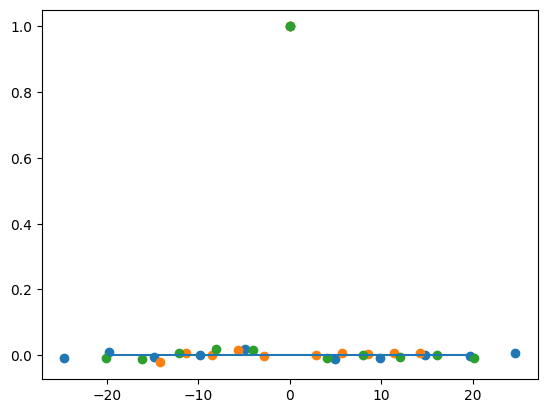

In [80]:
time = 400*us

para_d = np.sqrt(6)*k_vals*a
para_means=np.mean(para_sin_distros[time], axis=1)

perp_d = np.sqrt(2)*k_vals*a
perp_means=np.mean(perp_sin_distros[time], axis=1)
#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")

horiz_d = 2*k_vals*a
horiz_means=np.mean(horiz_sin_distros[time],axis=1)

#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(para_d,para_means/np.max(para_means))
plt.scatter(perp_d,perp_means/np.max(perp_means))
plt.scatter(horiz_d,horiz_means/np.max(horiz_means))


t = np.arange(-20,20,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")
plt.hlines(y=0,xmin=-20,xmax=20)
plt.show()

In [156]:
off_site_corr = []

para = np.mean(distro_para, axis=1)
perp = np.mean(distro_perp,axis=1)
horiz = np.mean(distro_horiz,axis=1)

para=para/np.max(para)
perp=perp/np.max(perp)
horiz=horiz/np.max(horiz)
off_site_corr.append( (np.trapz(para,para_d)+np.trapz(perp,perp_d)+np.trapz(horiz,horiz_d))/(3*2*a) -1)

for time in times[1:]:
    para = np.mean(para_sin_distros[time], axis=1)
    para=para/np.max(para)
    perp = np.mean(perp_sin_distros[time], axis=1)
    perp=perp/np.max(perp)
    horiz = np.mean(horiz_sin_distros[time], axis=1)
    horiz=horiz/np.max(horiz)
    
    off_site_corr.append( (np.trapz(para,para_d)+np.trapz(perp,perp_d)+np.trapz(horiz,horiz_d))/(3*2*a) - 1)
                         

In [157]:
x=np.arange(0,400,1)
x0=45
y=np.exp(-(x/x0)**2)

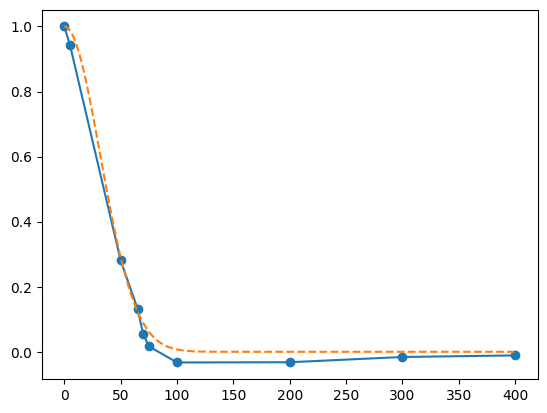

In [160]:
plt.scatter(np.array(times)/us,off_site_corr/off_site_corr[0])
plt.plot(np.array(times)/us,off_site_corr/off_site_corr[0])
plt.plot(x,y,linestyle='--')
plt.show()

In [152]:
a

2.0116